In [470]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 150) # visualize all columns - previously truncated - in pandas dataframe

#Linear regression with SKLearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [585]:
!ipython nbconvert --to script lee_v1.ipynb

[TerminalIPythonApp] WARNING | File not found: 'nbconvert\u200a--to'
]0;IPython: john_mod_project/dsc-1-final-project

In [471]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [472]:
np.random.seed(3)

In [473]:
kc_housing = pd.read_csv('kc_house_data.csv')

In [476]:
kc_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [477]:
kc=kc_housing.copy()

In [479]:
kc.yr_built.describe()

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

### Model Iteration 3

In [483]:
kc = kc_housing.copy()

In [484]:
# yr_renovated: creates new dummy var column ('yr_renovated_new') - by collapsing non-neg values into value of 1
kc['yr_renovated_new'] = np.where(kc['yr_renovated']>0, 1, 0) 

# sqft_basement: creates new dummy var column ('basement') - by converting "?" to "0.0", converting type, and filtering
kc['sqft_basement'] = kc['sqft_basement'].str.replace('?', '0.0')
kc["sqft_basement"] = kc["sqft_basement"].astype('float64')
kc['basement'] = np.where(kc['sqft_basement']>0, 1, 0)

# waterfront: creates new dummy var column ( 'waterfront_new') - by converting NaN values in waterfront col to 0.0
kc['waterfront_new'] = kc['waterfront'].fillna(0.0)

# view: creates new column of binary vars ("view_new") by converting non-zero values into 1
kc["view_new"] = np.where(kc['sqft_basement']>0, 1, 0)

# zipcode: creates 70 columns of zipcode dummy vars from the 'zipcode' column
df_zip_dums = pd.get_dummies(kc['zipcode'])
kc = pd.concat([kc, df_zip_dums], axis=1)

# yr_built: creates scalar column for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built
kc['yr_built_scalar_1899refyr'] = kc['yr_built'].apply(lambda x: abs(1899-x))

In [485]:
kc = kc.drop(columns=['id', 'date', 'waterfront', 'view', 'sqft_above', 'sqft_basement',
                          'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long'])
kc.columns

Index([                    'price',                  'bedrooms',
                       'bathrooms',               'sqft_living',
                        'sqft_lot',                    'floors',
                       'condition',                     'grade',
                   'sqft_living15',                'sqft_lot15',
                'yr_renovated_new',                  'basement',
                  'waterfront_new',                  'view_new',
                             98001,                       98002,
                             98003,                       98004,
                             98005,                       98006,
                             98007,                       98008,
                             98010,                       98011,
                             98014,                       98019,
                             98022,                       98023,
                             98024,                       98027,
                         

In [486]:
X = kc.drop(['price'], axis=1)
y = kc.price

In [487]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = model.predict(X_test)
y_hat_test

# See the R Squared score for our test data
r2 = r2_score(y_test, y_hat_test)
f"the r2 score is: {r2}"

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
f"the test MSE is: {test_mse}"

test_mse = np.sqrt(test_mse)
f"the test RMSE is: {test_mse}"

# compute with sklearn linear_model, although could not find any function to compute adjusted-r-square directly from documentation
# print model.score(X, y), 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
# 0.877643371323 0.863248473832

# model.coef_
# model.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([842305.66115284, 313411.4790976 , 761560.8676815 , ...,
       443237.76988196, 441796.821661  , 289125.46729469])

'the r2 score is: 0.7760357477127873'

'the test MSE is: 30907422752.848427'

'the test RMSE is: 175805.070327475'

In [488]:
#statsmodels model 4
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     1038.
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:12:44   Log-Likelihood:            -2.9011e+05
No. Observations:               21597   AIC:                         5.804e+05
Df Residuals:                   21514   BIC:                         5.810e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
bedrooms              

In [489]:
X.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_living15,sqft_lot15,yr_renovated_new,basement,waterfront_new,view_new,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199,yr_built_scalar_1899refyr
bedrooms,1.000000,0.514508,0.578212,0.032471,0.177944,0.026496,0.356563,0.393406,0.030690,0.017635,0.158412,-0.002127,0.158412,0.002837,-0.004848,-0.001987,0.063470,0.045691,0.077650,0.038718,0.045006,-0.006126,0.018087,-0.030617,-0.001021,-0.024173,0.008575,-0.002350,0.024572,0.013356,0.007107,0.014993,0.015265,0.001549,0.028840,0.016448,0.012333,0.035717,0.081357,0.005364,-0.014489,0.043442,-0.021942,-0.018070,0.009378,0.023737,0.055392,0.022368,-0.047442,0.009449,0.039381,0.067648,0.025231,0.017793,-0.009252,-0.057292,0.023200,-0.036820,-0.045445,-0.016995,-0.013882,0.016501,-0.030405,-0.041223,-0.061832,-0.040349,-0.011242,-0.026158,-0.024439,-0.074845,-0.038821,-0.052938,-0.021195,-0.031151,-0.012931,-0.007890,0.000560,-0.045699,0.002700,-0.008118,0.005210,-0.023639,-0.021325,0.155670
bathrooms,0.514508,1.000000,0.755758,0.088373,0.502582,-0.126479,0.665838,0.569884,0.088303,0.046742,0.159863,0.063629,0.159863,-0.017643,-0.034692,-0.010210,0.065358,0.035497,0.087887,0.006107,-0.004119,-0.007834,0.020156,-0.006665,0.021436,-0.026805,-0.010840,0.005931,0.066150,0.004088,0.074677,0.006592,0.005864,-0.040466,0.040518,0.001584,0.056574,0.067918,0.089821,0.002163,0.000611,0.053446,0.061772,-0.025723,-0.012758,-0.003019,0.043854,0.068472,-0.019730,0.018665,0.072131,0.104751,0.043792,0.020760,0.015182,-0.039863,0.005865,-0.050823,-0.010269,-0.022348,0.003930,0.037648,-0.053976,-0.020849,-0.063873,-0.070680,0.013062,-0.007763,-0.053507,-0.073387,-0.075635,-0.036214,-0.011188,-0.072893,-0.021539,-0.056804,-0.028999,-0.099712,-0.002250,-0.055332,-0.026073,-0.048801,0.008278,0.507173
sqft_living,0.578212,0.755758,1.000000,0.173453,0.353953,-0.059445,0.762779,0.756402,0.184342,0.050829,0.201198,0.104637,0.201198,-0.025071,-0.047539,-0.018905,0.110169,0.055598,0.135207,0.008983,0.006668,0.004254,0.017963,0.003116,0.009362,-0.027642,-0.015175,0.018778,0.065967,0.005322,0.027278,-0.014056,-0.018564,-0.028445,0.046843,-0.017817,0.012396,0.090278,0.128606,-0.017317,-0.001088,0.050994,0.081094,-0.036098,-0.009532,-0.004904,0.052414,0.065256,-0.015054,0.035907,0.088939,0.132558,0.081380,0.016148,0.005359,-0.079216,0.007922,-0.080999,-0.060911,-0.038141,-0.001981,0.051184,-0.044454,-0.030793,-0.068559,-0.066036,-0.007543,-0.037521,-0.050552,-0.075468,-0.077506,-0.042750,-0.023275,-0.058106,-0.026323,-0.046455,-0.001475,-0.074826,0.028933,-0.042364,-0.024066,-0.041815,0.010832,0.318152
sqft_lot,0.032471,0.088373,0.173453,1.000000,-0.004814,-0.008830,0.114731,0.144763,0.718204,0.005091,-0.034889,0.021459,-0.034889,-0.000417,-0.017656,-0.012444,-0.005880,0.010326,-0.006366,-0.008685,-0.013665,0.066482,-0.008725,0.150111,0.056280,0.149126,-0.017191,0.129037,0.059799,-0.008804,-0.019042,-0.008782,-0.008177,-0.008696,-0.015889,-0.020690,0.041726,0.002680,-0.003875,0.015083,0.085972,-0.015870,0.068252,-0.013596,-0.018493,0.015656,-0.002492,0.005919,0.144661,0.042810,-0.002012,0.012253,0.092284,0.053991,-0.019308,-0.047502,-0.024944,-0.028932,-0.032103,-0.022270,-0.019741,-0.027415,-0.038835,-0.030441,-0.040957,-0.034892,-0.025707,-0.032653,-0.024866,-0.031125,-0.029544,-0.024444,-0.033762,-0.017066,-0.007625,-0.016883,-0.003925,-0.010386,-0.008433,-0.018171,-0.009560,-0.012657,-0.028480,0.052946
floors,0.177944,0.502582,0.353953,-0.004814,1.000000,-0.264075,0.458794,0.280102,-0.010722,0.003713,-0.252465,0.020797,-0.252465,-0.015305,-0.028578,-0.038944,-0.014004,-0.035166,-0.0

In [140]:
# import seaborn as sns
# sns.heatmap(data_pred.corr(), center=0);

#### interpretation of results

In [ ]:
# p-value tests the null hypothesis that the coefficient is equal to zero (no effect)

### Model Iteration 4

In [490]:
kc = kc_housing.copy()


# yr_renovated: creates new dummy var column ('yr_renovated_new') - by collapsing non-neg values into value of 1
kc['yr_renovated_new'] = np.where(kc['yr_renovated']>0, 1, 0) 

# sqft_basement: creates new dummy var column ('basement') - by converting "?" to "0.0", converting type, and filtering
kc['sqft_basement'] = kc['sqft_basement'].str.replace('?', '0.0')
kc["sqft_basement"] = kc["sqft_basement"].astype('float64')
kc['basement'] = np.where(kc['sqft_basement']>0, 1, 0)

# waterfront: creates new dummy var column ( 'waterfront_new') - by converting NaN values in waterfront col to 0.0
kc['waterfront_new'] = kc['waterfront'].fillna(0.0)

# view: creates new column of binary vars ("view_new") by converting non-zero values into 1
kc["view_new"] = np.where(kc['sqft_basement']>0, 1, 0)

# yr_built: creates scalar column for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built
kc['yr_built_scalar_1899refyr'] = kc_housing['yr_built'].apply(lambda x: abs(1899-x))

# zipcode: creates 70 columns of zipcode dummy vars from the 'zipcode' column
# df_zip_dums = pd.get_dummies(kc_2['zipcode'])
# kc_2 = pd.concat([kc_2, df_zip_dums], axis=1)

In [491]:
kc = kc.drop(columns=['id', 'date', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long'])

In [492]:
X = kc.drop(['price'], axis=1)
y = kc.price

In [493]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = model.predict(X_test)
y_hat_test

# See the R Squared score for our test data
r2 = r2_score(y_test, y_hat_test)
f"the r2 score is: {r2}"

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
f"the test MSE is: {test_mse}"

test_mse = np.sqrt(test_mse)
f"the test RMSE is: {test_mse}"

# compute with sklearn linear_model, although could not find any function to compute adjusted-r-square directly from documentation
# print model.score(X, y), 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
# 0.877643371323 0.863248473832

# model.coef_
# model.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([649473.25878192, 569028.11317731, 853803.27495791, ...,
       412520.17689684, 363388.68496469, 252614.4488591 ])

'the r2 score is: 0.6366478891229802'

'the test MSE is: 43147068822.771255'

'the test RMSE is: 207718.72525791038'

In [494]:
#statsmodels model 5
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 1.238e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:12:59   Log-Likelihood:            -2.9677e+05
No. Observations:               21597   AIC:                         5.936e+05
Df Residuals:                   21584   BIC:                         5.937e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
bedrooms              

In [495]:
X.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_living15,sqft_lot15,yr_renovated_new,basement,waterfront_new,view_new,yr_built_scalar_1899refyr
bedrooms,1.000000,0.514508,0.578212,0.032471,0.177944,0.026496,0.356563,0.393406,0.030690,0.017635,0.158412,-0.002127,0.158412,0.155670
bathrooms,0.514508,1.000000,0.755758,0.088373,0.502582,-0.126479,0.665838,0.569884,0.088303,0.046742,0.159863,0.063629,0.159863,0.507173
sqft_living,0.578212,0.755758,1.000000,0.173453,0.353953,-0.059445,0.762779,0.756402,0.184342,0.050829,0.201198,0.104637,0.201198,0.318152
sqft_lot,0.032471,0.088373,0.173453,1.000000,-0.004814,-0.008830,0.114731,0.144763,0.718204,0.005091,-0.034889,0.021459,-0.034889,0.052946
floors,0.177944,0.502582,0.353953,-0.004814,1.000000,-0.264075,0.458794,0.280102,-0.010722,0.003713,-0.252465,0.020797,-0.252465,0.489193
condition,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,1.000000,-0.146896,-0.093072,-0.003126,-0.055383,0.130542,0.016648,0.130542,-0.361592
grade,0.356563,0.665838,0.762779,0.114731,0.458794,-0.146896,1.000000,0.713867,0.120981,0.015259,0.050701,0.082818,0.050701,0.447865
sqft_living15,0.393406,0.569884,0.756402,0.144763,0.280102,-0.093072,0.713867,1.000000,0.183515,0.000622,0.044577,0.083823,0.044577,0.326377
sqft_lot15,0.030690,0.088303,0.184342,0.718204,-0.010722,-0.003126,0.120981,0.183515,1.000000,0.004380,-0.041747,0.030658,-0.041747,0.070777
yr_renovated_new,0.017635,0.046742,0.050829,0.005091,0.003713,-0.055383,0.015259,0.000622,0.004380,1.000000,0.044600,0.074267,0.044600,-0.202837


In [496]:
abs(X.corr()) > 0.75

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_living15,sqft_lot15,yr_renovated_new,basement,waterfront_new,view_new,yr_built_scalar_1899refyr
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,True,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,True,True,False,False,False,True,True,False,False,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,True,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,True,False,False,False,False,False,False,False,False
grade,False,False,True,False,False,False,True,False,False,False,False,False,False,False
sqft_living15,False,False,True,False,False,False,False,True,False,False,False,False,False,False
sqft_lot15,False,False,False,False,False,False,False,False,True,False,False,False,False,False
yr_renovated_new,False,False,False,False,False,False,False,False,False,True,False,False,False,False


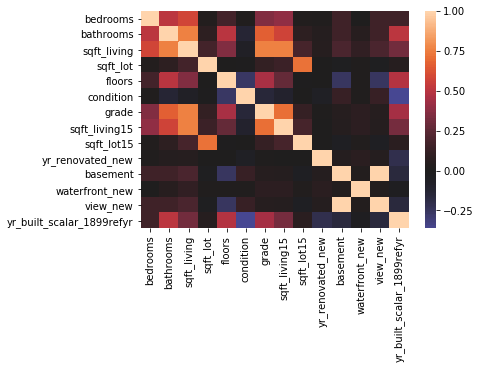

In [497]:
sns.heatmap(X.corr(), center=0);

#### Interpretation of results

### Model Iteration 5

In [498]:
kc = kc_housing.copy()


# yr_renovated: creates new dummy var column ('yr_renovated_new') - by collapsing non-neg values into value of 1
kc['yr_renovated_new'] = np.where(kc['yr_renovated']>0, 1, 0) 

# sqft_basement: creates new dummy var column ('basement') - by converting "?" to "0.0", converting type, and filtering
kc['sqft_basement'] = kc['sqft_basement'].str.replace('?', '0.0')
kc["sqft_basement"] = kc["sqft_basement"].astype('float64')
kc['basement'] = np.where(kc['sqft_basement']>0, 1, 0)

# waterfront: creates new dummy var column ( 'waterfront_new') - by converting NaN values in waterfront col to 0.0
kc['waterfront_new'] = kc['waterfront'].fillna(0.0)

# view: creates new column of binary vars ("view_new") by converting non-zero values into 1
kc["view_new"] = np.where(kc['sqft_basement']>0, 1, 0)

# yr_built: creates scalar column for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built
kc['yr_built_scalar_1899refyr'] = kc_housing['yr_built'].apply(lambda x: abs(1899-x))

# zipcode: creates 70 columns of zipcode dummy vars from the 'zipcode' column
# df_zip_dums = pd.get_dummies(kc_2['zipcode'])
# kc_2 = pd.concat([kc_2, df_zip_dums], axis=1)

In [499]:
kc = kc.drop(columns=['id', 'date', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 
                      'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'yr_renovated_new'])
kc.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_living15', 'sqft_lot15', 'basement',
       'waterfront_new', 'view_new', 'yr_built_scalar_1899refyr'],
      dtype='object')

In [500]:
X = kc.drop(['price'], axis=1)
y = kc.price

In [501]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = model.predict(X_test)
y_hat_test

# See the R Squared score for our test data
r2 = r2_score(y_test, y_hat_test)
f"the r2 score is: {r2}"

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
f"the test MSE is: {test_mse}"

test_mse = np.sqrt(test_mse)
f"the test RMSE is: {test_mse}"

# compute with sklearn linear_model, although could not find any function to compute adjusted-r-square directly from documentation
# print model.score(X, y), 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
# 0.877643371323 0.863248473832

# model.coef_
# model.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([564169.67298519, 928104.84539674, 858054.47753546, ...,
       443668.29234597, 365411.28168487, 985546.23749892])

'the r2 score is: 0.6569750737971807'

'the test MSE is: 41219590747.541756'

'the test RMSE is: 203026.08390928924'

In [502]:
#statsmodels model 5
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 1.341e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:13:08   Log-Likelihood:            -2.9677e+05
No. Observations:               21597   AIC:                         5.936e+05
Df Residuals:                   21585   BIC:                         5.937e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
bedrooms              

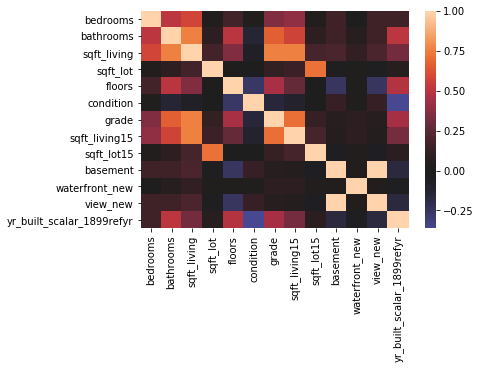

In [503]:
X.corr()
abs(X.corr()) > 0.75
sns.heatmap(X.corr(), center=0);

### Model Iteration 6

In [504]:
kc = kc_housing.copy()


# yr_renovated: creates new dummy var column ('yr_renovated_new') - by collapsing non-neg values into value of 1
kc['yr_renovated_new'] = np.where(kc['yr_renovated']>0, 1, 0) 

# sqft_basement: creates new dummy var column ('basement') - by converting "?" to "0.0", converting type, and filtering
kc['sqft_basement'] = kc['sqft_basement'].str.replace('?', '0.0')
kc["sqft_basement"] = kc["sqft_basement"].astype('float64')
kc['basement'] = np.where(kc['sqft_basement']>0, 1, 0)

# waterfront: creates new dummy var column ( 'waterfront_new') - by converting NaN values in waterfront col to 0.0
kc['waterfront_new'] = kc['waterfront'].fillna(0.0)

# view: creates new column of binary vars ("view_new") by converting non-zero values into 1
kc["view_new"] = np.where(kc['sqft_basement']>0, 1, 0)

# yr_built: creates scalar column for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built
kc['yr_built_scalar_1899refyr'] = kc_housing['yr_built'].apply(lambda x: abs(1899-x))

# zipcode: creates 70 columns of zipcode dummy vars from the 'zipcode' column
# df_zip_dums = pd.get_dummies(kc_2['zipcode'])
# kc_2 = pd.concat([kc_2, df_zip_dums], axis=1)

In [505]:
kc = kc.drop(columns=['id', 'date', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 
                      'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'yr_renovated_new', 'waterfront_new', 'floors'])
kc.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'condition', 'grade', 'sqft_living15', 'sqft_lot15', 'basement',
       'view_new', 'yr_built_scalar_1899refyr'],
      dtype='object')

In [506]:
X = kc.drop(['price'], axis=1)
y = kc.price

In [507]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = model.predict(X_test)
y_hat_test

# See the R Squared score for our test data
r2 = r2_score(y_test, y_hat_test)
f"the r2 score is: {r2}"

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
f"the test MSE is: {test_mse}"

test_mse = np.sqrt(test_mse)
f"the test RMSE is: {test_mse}"

# compute with sklearn linear_model, although could not find any function to compute adjusted-r-square directly from documentation
# print model.score(X, y), 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
# 0.877643371323 0.863248473832

# model.coef_
# model.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([481912.96607259, 337630.53706428, 316327.4813984 , ...,
       263083.79805436, 378569.94163924, 944860.36660292])

'the r2 score is: 0.6108250044784485'

'the test MSE is: 51569432506.04891'

'the test RMSE is: 227089.0409201838'

In [508]:
#statsmodels model 5
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 1.483e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:13:10   Log-Likelihood:            -2.9755e+05
No. Observations:               21597   AIC:                         5.951e+05
Df Residuals:                   21587   BIC:                         5.952e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
bedrooms              

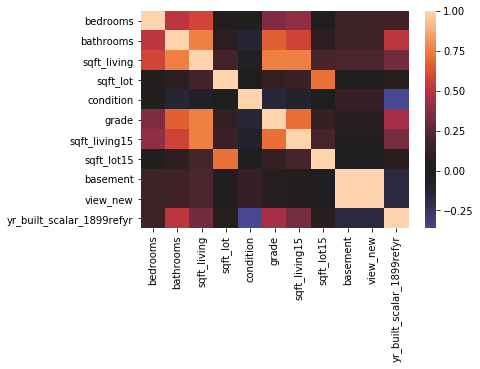

In [509]:
X.corr()
abs(X.corr()) > 0.75
sns.heatmap(X.corr(), center=0);

### Model Iteration 7

In [510]:
kc = kc_housing.copy()


# yr_renovated: creates new dummy var column ('yr_renovated_new') - by collapsing non-neg values into value of 1
kc['yr_renovated_new'] = np.where(kc['yr_renovated']>0, 1, 0) 

# sqft_basement: creates new dummy var column ('basement') - by converting "?" to "0.0", converting type, and filtering
kc['sqft_basement'] = kc['sqft_basement'].str.replace('?', '0.0')
kc["sqft_basement"] = kc["sqft_basement"].astype('float64')
kc['basement'] = np.where(kc['sqft_basement']>0, 1, 0)

# waterfront: creates new dummy var column ( 'waterfront_new') - by converting NaN values in waterfront col to 0.0
kc['waterfront_new'] = kc['waterfront'].fillna(0.0)

# view: creates new column of binary vars ("view_new") by converting non-zero values into 1
kc["view_new"] = np.where(kc['sqft_basement']>0, 1, 0)

# yr_built: creates scalar column for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built
kc['yr_built_scalar_1899refyr'] = kc_housing['yr_built'].apply(lambda x: abs(1899-x))

# zipcode: creates 70 columns of zipcode dummy vars from the 'zipcode' column
# df_zip_dums = pd.get_dummies(kc_2['zipcode'])
# kc_2 = pd.concat([kc_2, df_zip_dums], axis=1)

In [511]:
kc = kc.drop(columns=['id', 'date', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'yr_built',
                      'yr_renovated', 'zipcode', 'lat', 'long', 'yr_renovated_new', 'waterfront_new', 'floors'])
kc.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'condition', 'grade', 'sqft_living15', 'sqft_lot15', 'basement',
       'view_new', 'yr_built_scalar_1899refyr'],
      dtype='object')

In [512]:
X = kc.drop(['price'], axis=1)
y = kc.price

In [513]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = model.predict(X_test)
y_hat_test

# See the R Squared score for our test data
r2 = r2_score(y_test, y_hat_test)
f"the r2 score is: {r2}"

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
f"the test MSE is: {test_mse}"

test_mse = np.sqrt(test_mse)
f"the test RMSE is: {test_mse}"

# compute with sklearn linear_model, although could not find any function to compute adjusted-r-square directly from documentation
# print model.score(X, y), 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
# 0.877643371323 0.863248473832

# model.coef_
# model.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([599704.46646937, 205258.95525126, 698162.98001888, ...,
       700859.89876272, 470539.70567699, 602002.637662  ])

'the r2 score is: 0.62503274328966'

'the test MSE is: 53276551662.932434'

'the test RMSE is: 230817.13901470235'

In [514]:
#statsmodels model 5
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 1.483e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:13:12   Log-Likelihood:            -2.9755e+05
No. Observations:               21597   AIC:                         5.951e+05
Df Residuals:                   21587   BIC:                         5.952e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
bedrooms              

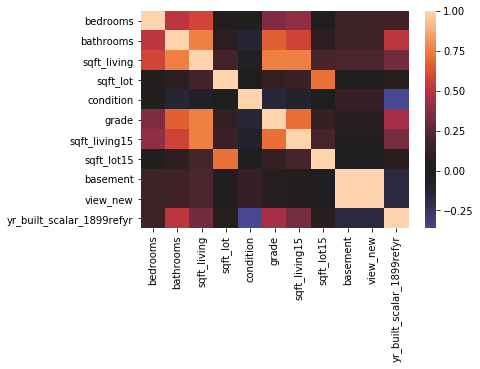

In [515]:
X.corr()
abs(X.corr()) > 0.75
sns.heatmap(X.corr(), center=0);

#### `Interpretation of Results

### Model Iteration 8

In [516]:
kc = kc_housing.copy()


# yr_renovated: creates new dummy var column ('yr_renovated_new') - by collapsing non-neg values into value of 1
kc['yr_renovated_new'] = np.where(kc['yr_renovated']>0, 1, 0) 

# sqft_basement: creates new dummy var column ('basement') - by converting "?" to "0.0", converting type, and filtering
kc['sqft_basement'] = kc['sqft_basement'].str.replace('?', '0.0')
kc["sqft_basement"] = kc["sqft_basement"].astype('float64')
kc['basement'] = np.where(kc['sqft_basement']>0, 1, 0)

# waterfront: creates new dummy var column ( 'waterfront_new') - by converting NaN values in waterfront col to 0.0
kc['waterfront_new'] = kc['waterfront'].fillna(0.0)

# view: creates new column of binary vars ("view_new") by converting non-zero values into 1
kc["view_new"] = np.where(kc['sqft_basement']>0, 1, 0)

# yr_built: creates scalar column for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built
kc['yr_built_scalar_1899refyr'] = kc_housing['yr_built'].apply(lambda x: abs(1899-x))

# zipcode: creates 70 columns of zipcode dummy vars from the 'zipcode' column
# df_zip_dums = pd.get_dummies(kc_2['zipcode'])
# kc_2 = pd.concat([kc_2, df_zip_dums], axis=1)

In [517]:
kc = kc.drop(columns=['id', 'date', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 
                      'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'yr_renovated_new',
                      'waterfront_new', 'floors', 'basement'])
kc.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'condition', 'grade', 'sqft_living15', 'sqft_lot15', 'view_new',
       'yr_built_scalar_1899refyr'],
      dtype='object')

In [518]:
X = kc.drop(['price'], axis=1)
y = kc.price

In [519]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = model.predict(X_test)
y_hat_test

# See the R Squared score for our test data
r2 = r2_score(y_test, y_hat_test)
f"the r2 score is: {r2}"

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
f"the test MSE is: {test_mse}"

test_mse = np.sqrt(test_mse)
f"the test RMSE is: {test_mse}"

# compute with sklearn linear_model, although could not find any function to compute adjusted-r-square directly from documentation
# print model.score(X, y), 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
# 0.877643371323 0.863248473832

# model.coef_
# model.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([1164566.71326953,  431200.56864218,  581590.23226353, ...,
        500219.64776597,  754119.71216517,  406246.56545777])

'the r2 score is: 0.6299788039071377'

'the test MSE is: 47126078673.68158'

'the test RMSE is: 217085.41792041578'

In [520]:
#statsmodels model 5
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 1.483e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:13:14   Log-Likelihood:            -2.9755e+05
No. Observations:               21597   AIC:                         5.951e+05
Df Residuals:                   21587   BIC:                         5.952e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
bedrooms              

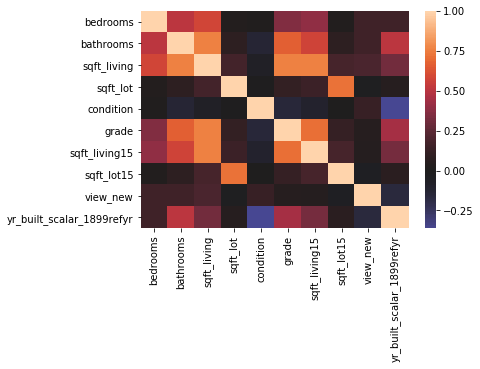

In [521]:
X.corr()
abs(X.corr()) > 0.75
sns.heatmap(X.corr(), center=0);

#### Interpretation of Results

### Model Iteration 9

In [522]:
kc = kc_housing.copy()


# yr_renovated: creates new dummy var column ('yr_renovated_new') - by collapsing non-neg values into value of 1
kc['yr_renovated_new'] = np.where(kc['yr_renovated']>0, 1, 0) 

# sqft_basement: creates new dummy var column ('basement') - by converting "?" to "0.0", converting type, and filtering
kc['sqft_basement'] = kc['sqft_basement'].str.replace('?', '0.0')
kc["sqft_basement"] = kc["sqft_basement"].astype('float64')
kc['basement'] = np.where(kc['sqft_basement']>0, 1, 0)

# waterfront: creates new dummy var column ( 'waterfront_new') - by converting NaN values in waterfront col to 0.0
kc['waterfront_new'] = kc['waterfront'].fillna(0.0)

# view: creates new column of binary vars ("view_new") by converting non-zero values into 1
kc["view_new"] = np.where(kc['sqft_basement']>0, 1, 0)

# yr_built: creates scalar column for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built
kc['yr_built_scalar_1899refyr'] = kc_housing['yr_built'].apply(lambda x: abs(1899-x))

# zipcode: creates 70 columns of zipcode dummy vars from the 'zipcode' column
# df_zip_dums = pd.get_dummies(kc_2['zipcode'])
# kc_2 = pd.concat([kc_2, df_zip_dums], axis=1)

In [523]:
kc = kc.drop(columns=['id', 'date', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 
                      'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 
                      'yr_renovated_new', 'waterfront_new', 'floors', 'basement', 'condition'])
kc.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'grade',
       'sqft_living15', 'sqft_lot15', 'view_new', 'yr_built_scalar_1899refyr'],
      dtype='object')

In [524]:
X = kc.drop(['price'], axis=1)
y = kc.price

In [525]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = model.predict(X_test)
y_hat_test

# See the R Squared score for our test data
r2 = r2_score(y_test, y_hat_test)
f"the r2 score is: {r2}"

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
f"the test MSE is: {test_mse}"

test_mse = np.sqrt(test_mse)
f"the test RMSE is: {test_mse}"

# compute with sklearn linear_model, although could not find any function to compute adjusted-r-square directly from documentation
# print model.score(X, y), 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
# 0.877643371323 0.863248473832

# model.coef_
# model.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([702885.6949783 , 344070.08581847, 225203.15779731, ...,
       735978.88215947, 716446.33772182, 392445.47950319])

'the r2 score is: 0.605048768805154'

'the test MSE is: 52295609562.74267'

'the test RMSE is: 228682.33329827353'

In [526]:
#statsmodels model 5
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                 1.627e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:13:17   Log-Likelihood:            -2.9767e+05
No. Observations:               21597   AIC:                         5.954e+05
Df Residuals:                   21588   BIC:                         5.954e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
bedrooms              

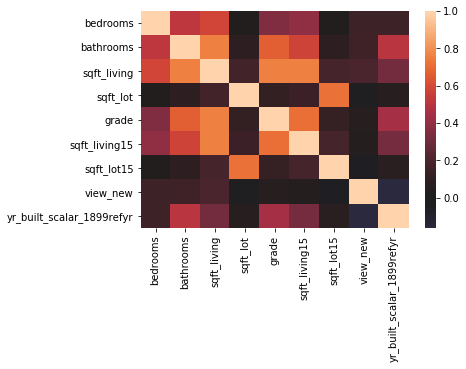

In [527]:
X.corr()
abs(X.corr()) > 0.75
sns.heatmap(X.corr(), center=0);

In [528]:
#### Interpretation of Results

### Model Iteration 10

In [529]:
kc = kc_housing.copy()


# yr_renovated: creates new dummy var column ('yr_renovated_new') - by collapsing non-neg values into value of 1
kc['yr_renovated_new'] = np.where(kc['yr_renovated']>0, 1, 0) 

# sqft_basement: creates new dummy var column ('basement') - by converting "?" to "0.0", converting type, and filtering
kc['sqft_basement'] = kc['sqft_basement'].str.replace('?', '0.0')
kc["sqft_basement"] = kc["sqft_basement"].astype('float64')
kc['basement'] = np.where(kc['sqft_basement']>0, 1, 0)

# waterfront: creates new dummy var column ( 'waterfront_new') - by converting NaN values in waterfront col to 0.0
kc['waterfront_new'] = kc['waterfront'].fillna(0.0)

# view: creates new column of binary vars ("view_new") by converting non-zero values into 1
kc["view_new"] = np.where(kc['sqft_basement']>0, 1, 0)

# yr_built: creates scalar column for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built
kc['yr_built_scalar_1899refyr'] = kc_housing['yr_built'].apply(lambda x: abs(1899-x))

# zipcode: creates 70 columns of zipcode dummy vars from the 'zipcode' column
# df_zip_dums = pd.get_dummies(kc_2['zipcode'])
# kc_2 = pd.concat([kc_2, df_zip_dums], axis=1)

In [530]:
kc = kc.drop(columns=['id', 'date', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 
                      'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 
                      'yr_renovated_new', 'waterfront_new', 'floors', 'basement', 'condition'])
kc.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'grade',
       'sqft_living15', 'sqft_lot15', 'view_new', 'yr_built_scalar_1899refyr'],
      dtype='object')

In [531]:
X = kc.drop(['price'], axis=1)
y = kc.price

In [532]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = model.predict(X_test)
y_hat_test

# See the R Squared score for our test data
r2 = r2_score(y_test, y_hat_test)
f"the r2 score is: {r2}"

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
f"the test MSE is: {test_mse}"

test_mse = np.sqrt(test_mse)
f"the test RMSE is: {test_mse}"

# compute with sklearn linear_model, although could not find any function to compute adjusted-r-square directly from documentation
# print model.score(X, y), 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
# 0.877643371323 0.863248473832

# model.coef_
# model.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([167048.45087056, 685819.10847693, 500655.1925287 , ...,
       210203.75729661, 576313.18002226, 719014.4082642 ])

'the r2 score is: 0.627414635523837'

'the test MSE is: 51316147537.562515'

'the test RMSE is: 226530.67681345614'

In [533]:
#statsmodels model 5
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                 1.627e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:13:20   Log-Likelihood:            -2.9767e+05
No. Observations:               21597   AIC:                         5.954e+05
Df Residuals:                   21588   BIC:                         5.954e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
bedrooms              

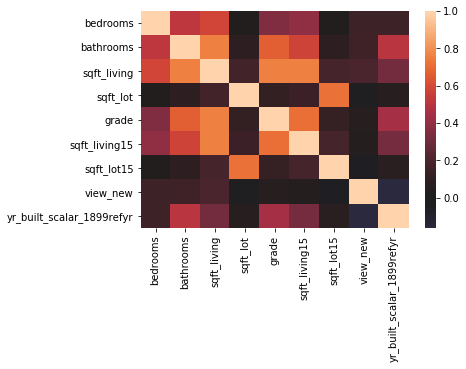

In [534]:
X.corr()
abs(X.corr()) > 0.75
sns.heatmap(X.corr(), center=0);

### Model Iteration 11 - Log Transform?

In [535]:
# data_log["logdisp"] = np.log(data_pred["displacement"])

### Model Iteration 13 - Pairwise Feature Selection

In [536]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [537]:
kc = kc_housing.copy()

In [538]:
# yr_renovated: creates new dummy var column ('yr_renovated_new') - by collapsing non-neg values into value of 1
kc['yr_renovated_new'] = np.where(kc['yr_renovated']>0, 1, 0) 

# sqft_basement: creates new dummy var column ('basement') - by converting "?" to "0.0", converting type, and filtering
kc['sqft_basement'] = kc['sqft_basement'].str.replace('?', '0.0')
kc["sqft_basement"] = kc["sqft_basement"].astype('float64')
kc['basement'] = np.where(kc['sqft_basement']>0, 1, 0)

# waterfront: creates new dummy var column ( 'waterfront_new') - by converting NaN values in waterfront col to 0.0
kc['waterfront_new'] = kc['waterfront'].fillna(0.0)

# view: creates new column of binary vars ("view_new") by converting non-zero values into 1
kc["view_new"] = np.where(kc['sqft_basement']>0, 1, 0)

# yr_built: creates scalar column for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built
kc['yr_built_scalar_1899refyr'] = kc_housing['yr_built'].apply(lambda x: abs(1899-x))

# zipcode: creates 70 columns of zipcode dummy vars from the 'zipcode' column
# df_zip_dums = pd.get_dummies(kc_2['zipcode'])
# kc_2 = pd.concat([kc_2, df_zip_dums], axis=1)

In [539]:
kc = kc.drop(columns=['id', 'date', 'yr_built', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 
                    'yr_renovated', 'zipcode', 'lat', 'long'])
kc.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_living15', 'sqft_lot15', 'yr_renovated_new',
       'basement', 'waterfront_new', 'view_new', 'yr_built_scalar_1899refyr'],
      dtype='object')

In [540]:
X = kc.drop(['price'], axis=1)
y = kc.price

In [541]:
kc.info()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
price                        21597 non-null float64
bedrooms                     21597 non-null int64
bathrooms                    21597 non-null float64
sqft_living                  21597 non-null int64
sqft_lot                     21597 non-null int64
floors                       21597 non-null float64
condition                    21597 non-null int64
grade                        21597 non-null int64
sqft_living15                21597 non-null int64
sqft_lot15                   21597 non-null int64
yr_renovated_new             21597 non-null int64
basement                     21597 non-null int64
waterfront_new               21597 non-null float64
view_new                     21597 non-null int64
yr_built_scalar_1899refyr    21597 non-null int64
dtypes: float64(4), int64(11)
memory usage: 2.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data c

In [542]:
outcome = kc.drop('price', axis=1)

In [543]:
predictors = pd.DataFrame(kc.price)

In [544]:
pred_sum = "+".join(predictors.columns)

In [545]:
formula = outcome + "~" + pred_sum

TypeError: Could not operate '~' with block values unsupported operand type(s) for +: 'int' and 'str'

In [546]:
result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

Add  bedrooms                       with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  waterfront_new                 with p-value 0.0
Add  grade                          with p-value 0.0
Add  yr_built_scalar_1899refyr      with p-value 0.0
Add  bathrooms                      with p-value 1.16609e-70
Add  sqft_lot15                     with p-value 2.0604e-24
Add  condition                      with p-value 1.01466e-12
Add  floors                         with p-value 7.01598e-11
Add  basement                       with p-value 2.89952e-06
Add  view_new                       with p-value 2.89952e-06
Add  yr_renovated_new               with p-value 0.000178863
resulting features:
['bedrooms', 'sqft_living15', 'sqft_living', 'waterfront_new', 'grade', 'yr_built_scalar_1899refyr', 'bathrooms', 'sqft_lot15', 'condition', 'floors', 'basement', 'view_new', 'yr_renovated_new']


In [547]:
model = ols(formula= formula, data=data_ols).fit()
model.summary()

NameError: name 'formula' is not defined

### Model Iteration 12 - using Feature Ranking with `RFE` from sklearn - 10 features

In [548]:
kc = kc_housing.copy()

In [549]:
# yr_renovated: creates new dummy var column ('yr_renovated_new') - by collapsing non-neg values into value of 1
kc['yr_renovated_new'] = np.where(kc['yr_renovated']>0, 1, 0) 

# sqft_basement: creates new dummy var column ('basement') - by converting "?" to "0.0", converting type, and filtering
kc['sqft_basement'] = kc['sqft_basement'].str.replace('?', '0.0')
kc["sqft_basement"] = kc["sqft_basement"].astype('float64')
kc['basement'] = np.where(kc['sqft_basement']>0, 1, 0)

# waterfront: creates new dummy var column ( 'waterfront_new') - by converting NaN values in waterfront col to 0.0
kc['waterfront_new'] = kc['waterfront'].fillna(0.0)

# view: creates new column of binary vars ("view_new") by converting non-zero values into 1
kc["view_new"] = np.where(kc['sqft_basement']>0, 1, 0)

# yr_built: creates scalar column for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built
kc['yr_built_scalar_1899refyr'] = kc_housing['yr_built'].apply(lambda x: abs(1899-x))

# zipcode: creates 70 columns of zipcode dummy vars from the 'zipcode' column
# df_zip_dums = pd.get_dummies(kc_2['zipcode'])
# kc_2 = pd.concat([kc_2, df_zip_dums], axis=1)

In [550]:
kc = kc.drop(columns=['id', 'date', 
                      'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_basement', 'waterfront', 'view'])
kc.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15',
       'yr_renovated_new', 'basement', 'waterfront_new', 'view_new',
       'yr_built_scalar_1899refyr'],
      dtype='object')

In [551]:
X = kc
X.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_living15,sqft_lot15,yr_renovated_new,basement,waterfront_new,view_new,yr_built_scalar_1899refyr
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1340,5650,0,0,0.0,0,56
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1690,7639,1,1,0.0,1,52
2,180000.0,2,1.00,770,10000,1.0,3,6,770,2720,8062,0,0,0.0,0,34
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1360,5000,0,1,0.0,1,66
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1800,7503,0,0,0.0,0,88


In [552]:
y

0         221900.0
1         538000.0
2         180000.0
3         604000.0
4         510000.0
5        1230000.0
6         257500.0
7         291850.0
8         229500.0
9         323000.0
10        662500.0
11        468000.0
12        310000.0
13        400000.0
14        530000.0
15        650000.0
16        395000.0
17        485000.0
18        189000.0
19        230000.0
20        385000.0
21       2000000.0
22        285000.0
23        252700.0
24        329000.0
25        233000.0
26        937000.0
27        667000.0
28        438000.0
29        719000.0
           ...    
21567     399950.0
21568     380000.0
21569     270000.0
21570     505000.0
21571     385000.0
21572     414500.0
21573     347500.0
21574    1220000.0
21575     572000.0
21576     475000.0
21577    1090000.0
21578     350000.0
21579     520000.0
21580     679950.0
21581    1580000.0
21582     541800.0
21583     810000.0
21584    1540000.0
21585     467000.0
21586     224000.0
21587     507250.0
21588     42

In [553]:
X = X.drop(['price'])

KeyError: "labels ['price'] not contained in axis"

In [554]:
X.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_living15,sqft_lot15,yr_renovated_new,basement,waterfront_new,view_new,yr_built_scalar_1899refyr
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1340,5650,0,0,0.0,0,56
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1690,7639,1,1,0.0,1,52
2,180000.0,2,1.00,770,10000,1.0,3,6,770,2720,8062,0,0,0.0,0,34
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1360,5000,0,1,0.0,1,66
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1800,7503,0,0,0.0,0,88


In [555]:
#Scikit-learn also provides a few functionalities for feature selection. 
#Their Feature Ranking with Recursive Feature Elimination selects the pre-specified  n
# most important features. See here for more information on how the algorithm works.

model = LinearRegression()
selector = RFE(model, n_features_to_select = 10)
selector = selector.fit(X, y)

#Calling the .support_ attribute tells you which variables are selected
selector.support_ 

# Calling .ranking_ shows the ranking of the features, selected features are assigned rank 1
selector.ranking_

#By calling .estimator_ on the RFE object, you can get access to the parameter estimates through .coef_ and .intercept
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)
[ 4.77870536 -6.26580459]
21.300812564199767

array([ True,  True,  True, False, False,  True,  True,  True, False,
       False, False,  True,  True,  True,  True, False])

array([1, 1, 1, 2, 6, 1, 1, 1, 4, 5, 7, 1, 1, 1, 1, 3])

[ 1.00000000e+00 -1.58531821e-11 -3.00280110e-11 -1.52122727e-11
 -1.36173302e-11  5.34370357e-11  1.54304420e-11  1.80267673e-12
 -1.07738353e-11  1.80267673e-12]
-6.984919309616089e-10


[-1.48709923]

21.300812564199767

In [556]:
estimators

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [557]:
X = X.drop(columns=['price', 'sqft_lot', 'floors', 'sqft_lot15', 'sqft_living15', 'sqft_lot15',
       'yr_renovated_new', 'yr_built_scalar_1899refyr'])
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'condition', 'grade',
       'sqft_above', 'basement', 'waterfront_new', 'view_new'],
      dtype='object')

In [558]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = model.predict(X_test)
y_hat_test

# See the R Squared score for our test data
r2 = r2_score(y_test, y_hat_test)
f"the r2 score is: {r2}"

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
f"the test MSE is: {test_mse}"

test_mse = np.sqrt(test_mse)
f"the test RMSE is: {test_mse}"

# compute with sklearn linear_model, although could not find any function to compute adjusted-r-square directly from documentation
# print model.score(X, y), 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
# 0.877643371323 0.863248473832

# model.coef_
# model.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([ 456157.68507735, 1230187.02875494,  283207.52060945, ...,
        803662.04657327,  396461.14414973,  316009.96955311])

'the r2 score is: 0.6099299666688245'

'the test MSE is: 49626745484.38223'

'the test RMSE is: 222770.61180591624'

In [559]:
#statsmodels model 5
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 1.659e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:13:35   Log-Likelihood:            -2.9859e+05
No. Observations:               21597   AIC:                         5.972e+05
Df Residuals:                   21589   BIC:                         5.973e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms       -6.911e+04   2148.315    -32.

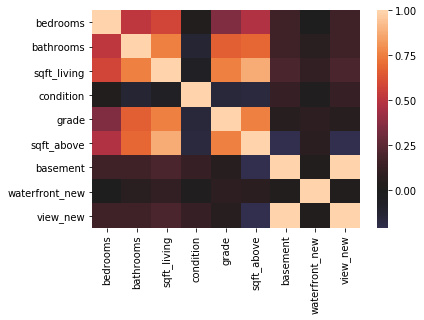

In [560]:
X.corr()
abs(X.corr()) > 0.75
sns.heatmap(X.corr(), center=0);

### Model Iteration 13 - using Feature Ranking with `RFE` from sklearn - 6 features

In [561]:
kc = kc_housing.copy()

In [562]:
# yr_renovated: creates new dummy var column ('yr_renovated_new') - by collapsing non-neg values into value of 1
kc['yr_renovated_new'] = np.where(kc['yr_renovated']>0, 1, 0) 

# sqft_basement: creates new dummy var column ('basement') - by converting "?" to "0.0", converting type, and filtering
kc['sqft_basement'] = kc['sqft_basement'].str.replace('?', '0.0')
kc["sqft_basement"] = kc["sqft_basement"].astype('float64')
kc['basement'] = np.where(kc['sqft_basement']>0, 1, 0)

# waterfront: creates new dummy var column ( 'waterfront_new') - by converting NaN values in waterfront col to 0.0
kc['waterfront_new'] = kc['waterfront'].fillna(0.0)

# view: creates new column of binary vars ("view_new") by converting non-zero values into 1
kc["view_new"] = np.where(kc['sqft_basement']>0, 1, 0)

# yr_built: creates scalar column for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built
kc['yr_built_scalar_1899refyr'] = kc_housing['yr_built'].apply(lambda x: abs(1899-x))

# zipcode: creates 70 columns of zipcode dummy vars from the 'zipcode' column
# df_zip_dums = pd.get_dummies(kc_2['zipcode'])
# kc_2 = pd.concat([kc_2, df_zip_dums], axis=1)

In [563]:
kc = kc.drop(columns=['id', 'date', 
                      'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_basement', 'waterfront', 'view'])
kc.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15',
       'yr_renovated_new', 'basement', 'waterfront_new', 'view_new',
       'yr_built_scalar_1899refyr'],
      dtype='object')

In [564]:
X = kc

In [565]:
y

0         221900.0
1         538000.0
2         180000.0
3         604000.0
4         510000.0
5        1230000.0
6         257500.0
7         291850.0
8         229500.0
9         323000.0
10        662500.0
11        468000.0
12        310000.0
13        400000.0
14        530000.0
15        650000.0
16        395000.0
17        485000.0
18        189000.0
19        230000.0
20        385000.0
21       2000000.0
22        285000.0
23        252700.0
24        329000.0
25        233000.0
26        937000.0
27        667000.0
28        438000.0
29        719000.0
           ...    
21567     399950.0
21568     380000.0
21569     270000.0
21570     505000.0
21571     385000.0
21572     414500.0
21573     347500.0
21574    1220000.0
21575     572000.0
21576     475000.0
21577    1090000.0
21578     350000.0
21579     520000.0
21580     679950.0
21581    1580000.0
21582     541800.0
21583     810000.0
21584    1540000.0
21585     467000.0
21586     224000.0
21587     507250.0
21588     42

In [566]:
X = X.columns.drop(['price'])

In [567]:
#Scikit-learn also provides a few functionalities for feature selection. 
#Their Feature Ranking with Recursive Feature Elimination selects the pre-specified  n
# most important features. See here for more information on how the algorithm works.

model = LinearRegression()
selector = RFE(model, n_features_to_select = 6)
selector = selector.fit(X, y)

#Calling the .support_ attribute tells you which variables are selected
selector.support_ 

# Calling .ranking_ shows the ranking of the features, selected features are assigned rank 1
selector.ranking_

#By calling .estimator_ on the RFE object, you can get access to the parameter estimates through .coef_ and .intercept
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)
[ 4.77870536 -6.26580459]
21.300812564199767

ValueError: could not convert string to float: 'yr_built_scalar_1899refyr'

In [568]:
X.columns()

AttributeError: 'Index' object has no attribute 'columns'

In [569]:
estimators

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [570]:
X = X.drop(columns=['price', 'sqft_lot', 'floors', 'sqft_lot15', 'sqft_living15', 'sqft_lot15',
       'yr_renovated_new', 'yr_built_scalar_1899refyr'])

TypeError: drop() got an unexpected keyword argument 'columns'

In [571]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = model.predict(X_test)
y_hat_test

# See the R Squared score for our test data
r2 = r2_score(y_test, y_hat_test)
f"the r2 score is: {r2}"

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
f"the test MSE is: {test_mse}"

test_mse = np.sqrt(test_mse)
f"the test RMSE is: {test_mse}"

# compute with sklearn linear_model, although could not find any function to compute adjusted-r-square directly from documentation
# print model.score(X, y), 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
# 0.877643371323 0.863248473832

# model.coef_
# model.intercept_

ValueError: Found input variables with inconsistent numbers of samples: [15, 21597]

In [572]:
#statsmodels model 5
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [573]:
X.corr()
abs(X.corr()) > 0.75
sns.heatmap(X.corr(), center=0);

AttributeError: 'Index' object has no attribute 'corr'

### Model Iteration 14 - RFE with zipcode dummies

In [574]:
kc = kc_housing.copy()

In [575]:
# yr_renovated: creates new dummy var column ('yr_renovated_new') - by collapsing non-neg values into value of 1
kc['yr_renovated_new'] = np.where(kc['yr_renovated']>0, 1, 0) 

# sqft_basement: creates new dummy var column ('basement') - by converting "?" to "0.0", converting type, and filtering
kc['sqft_basement'] = kc['sqft_basement'].str.replace('?', '0.0')
kc["sqft_basement"] = kc["sqft_basement"].astype('float64')
kc['basement'] = np.where(kc['sqft_basement']>0, 1, 0)

# waterfront: creates new dummy var column ( 'waterfront_new') - by converting NaN values in waterfront col to 0.0
kc['waterfront_new'] = kc['waterfront'].fillna(0.0)

# view: creates new column of binary vars ("view_new") by converting non-zero values into 1
kc["view_new"] = np.where(kc['sqft_basement']>0, 1, 0)

# zipcode: creates 70 columns of zipcode dummy vars from the 'zipcode' column
df_zip_dums = pd.get_dummies(kc['zipcode'])
kc = pd.concat([kc, df_zip_dums], axis=1)

# yr_built: creates scalar column for "newness" of yr_home_built (abs val from 1899 ref yr) from yr_built
kc['yr_built_scalar_1899refyr'] = kc['yr_built'].apply(lambda x: abs(1899-x))

In [576]:
kc = kc.drop(columns=['id', 'date', 'waterfront', 'view', 'sqft_above', 'sqft_basement',
                          'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long'])
kc.columns

Index([                    'price',                  'bedrooms',
                       'bathrooms',               'sqft_living',
                        'sqft_lot',                    'floors',
                       'condition',                     'grade',
                   'sqft_living15',                'sqft_lot15',
                'yr_renovated_new',                  'basement',
                  'waterfront_new',                  'view_new',
                             98001,                       98002,
                             98003,                       98004,
                             98005,                       98006,
                             98007,                       98008,
                             98010,                       98011,
                             98014,                       98019,
                             98022,                       98023,
                             98024,                       98027,
                         

In [577]:
X = kc
X.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_living15,sqft_lot15,yr_renovated_new,basement,waterfront_new,view_new,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199,yr_built_scalar_1899refyr
0,221900.0,3,1.00,1180,5650,1.0,3,7,1340,5650,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,56
1,538000.0,3,2.25,2570,7242,2.0,3,7,1690,7639,1,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52
2,180000.0,2,1.00,770,10000,1.0,3,6,2720,8062,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34
3,604000.0,4,3.00,1960,5000,1.0,5,7,1360,5000,0,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,66
4,510000.0,3,2.00,1680,8080,1.0,3,8,1800,7503,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88


In [578]:
X = X.columns.drop(['price'])

In [579]:
#Scikit-learn also provides a few functionalities for feature selection. 
#Their Feature Ranking with Recursive Feature Elimination selects the pre-specified  n
# most important features. See here for more information on how the algorithm works.

model = LinearRegression()
selector = RFE(model, n_features_to_select = 6)
selector = selector.fit(X, y)

#Calling the .support_ attribute tells you which variables are selected
selector.support_ 

# Calling .ranking_ shows the ranking of the features, selected features are assigned rank 1
selector.ranking_

#By calling .estimator_ on the RFE object, you can get access to the parameter estimates through .coef_ and .intercept
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)
[ 4.77870536 -6.26580459]
21.300812564199767

ValueError: could not convert string to float: 'yr_built_scalar_1899refyr'

In [580]:
X.columns()

AttributeError: 'Index' object has no attribute 'columns'

In [581]:
estimators

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [582]:
X = X.drop(columns=['price', 'sqft_lot', 'floors', 'sqft_lot15', 'sqft_living15', 'sqft_lot15',
       'yr_renovated_new', 'yr_built_scalar_1899refyr'])

TypeError: drop() got an unexpected keyword argument 'columns'

In [445]:
X = kc

In [446]:
X = kc.drop(['price'], axis=1)
y = kc.price

In [447]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = model.predict(X_test)
y_hat_test

# See the R Squared score for our test data
r2 = r2_score(y_test, y_hat_test)
f"the r2 score is: {r2}"

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
f"the test MSE is: {test_mse}"

test_mse = np.sqrt(test_mse)
f"the test RMSE is: {test_mse}"

# compute with sklearn linear_model, although could not find any function to compute adjusted-r-square directly from documentation
# print model.score(X, y), 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
# 0.877643371323 0.863248473832

# model.coef_
# model.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([842305.66115284, 313411.4790976 , 761560.8676815 , ...,
       443237.76988196, 441796.821661  , 289125.46729469])

'the r2 score is: 0.7760357477127873'

'the test MSE is: 30907422752.848427'

'the test RMSE is: 175805.070327475'

In [ ]:
#statsmodels model 4
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

### Forward selection using adjusted R-squared

In [ ]:
This resource provides code for a forward selection procedure (much like stepwise selection, but without a backward pass), but this time looking at the adjusted-R-squared to make decisions on which variable to add in the mode.

cross-validation is the answer, per ME

In [ ]:
ME - 5 minute pres. Fri afternoon. Miles will do mid-project.

Notes: RMSLE
Median Absolute Error for typical customer in dollars

RMSE
- RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data –how close the observed data points are to the model’s predicted values. 
- Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.
- The best measure of model fit depends on the researcher’s objectives, and more than one are often useful. 
- The statistics discussed above are applicable to regression models that use OLS estimation. Many types of regression models, however, such as mixed models, generalized linear models, and event history models, use maximum likelihood estimation. These statistics are not available for such models.

- often referred to as mean squared prediction error or "out-of-sample mean squared error", refers to the mean value of the squared deviations of the predictions from the true values, over an out-of-sample test space, generated by a model estimated over a particular ...